## dir setup

In [1]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [197]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
interim_data_dir = os.path.join(project_dir, os.environ.get("INTERIM_DATA_DIR"))
wordvecs_data_dir = os.path.join(project_dir, os.environ.get("WORDVECS_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))
models_dir = os.path.join(project_dir, os.environ.get("MODELS_DIR"))

In [3]:
# import numpy as np
# from datetime import datetime

In [4]:
import pandas as pd
# pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
# pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# from tqdm import tqdm
# tqdm.pandas()

In [7]:
import sys
sys.path.insert(0, '..')

In [8]:
from src.features import *

In [9]:
from pathlib import Path
fns = sorted(Path(cv_dir).iterdir(), key=os.path.getmtime)
fns

[PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_128__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_256__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_200__factors_256__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_384__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../reports/cv/pred__alpha_val_200__buy_weight_100__factors_512__iterations_15__regularization_0.01.csv'),
 PosixPath('/Users/hitoshinagano/Documents/MercadoLibre_competicao/notebooks/../repor

In [12]:
# fns = os.listdir(cv_dir, )
# fns

In [10]:
fn = 'pred__alpha_val_200__buy_weight_200__factors_768__iterations_15__regularization_0.01.csv'
pred = pd.read_csv(os.path.join(cv_dir, fn), index_col = 0)

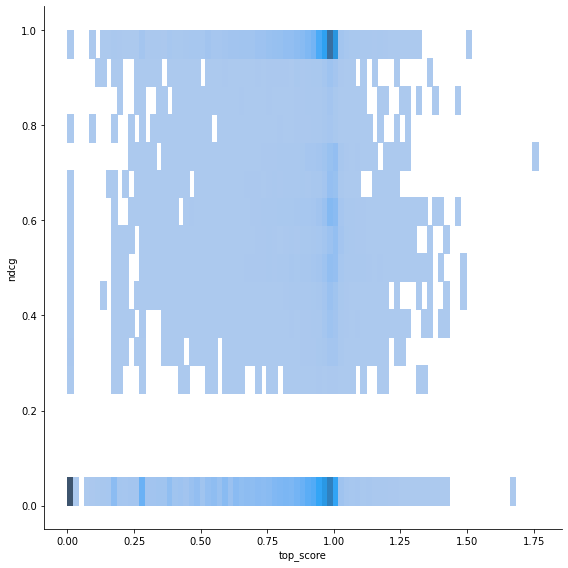

In [11]:
sns.displot(data = pred, x = 'top_score', y = 'ndcg', height = 8, );

<AxesSubplot:xlabel='top_score', ylabel='ndcg'>

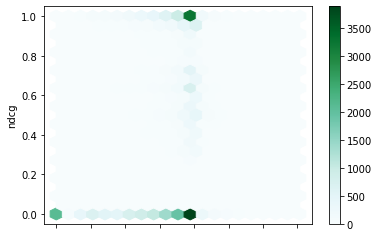

In [12]:
pred.plot.hexbin(x = 'top_score', y = 'ndcg', gridsize = 20)

In [13]:
pred['ndcg_cut'] = pd.cut(pred.ndcg, bins = np.arange(0, 1.11, 0.1), right = False)
pred['top_score_cut'] = pd.cut(pred.top_score, bins = np.arange(0, 2.01, 0.1), right = False)

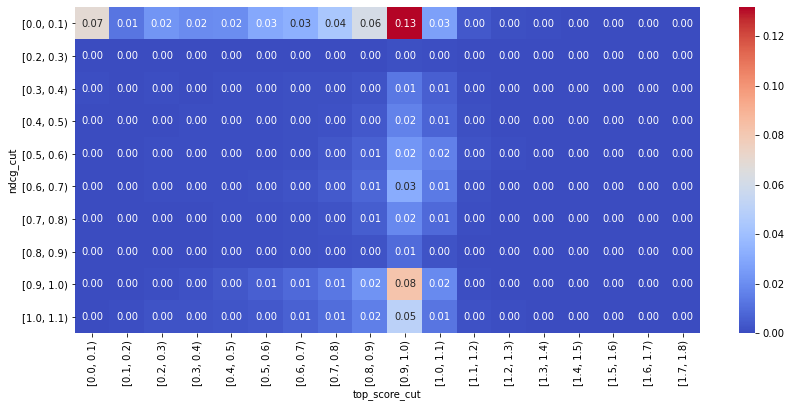

In [14]:
t = pd.crosstab(index = pred.ndcg_cut, columns = pred.top_score_cut)
plt.figure(figsize = (14, 6))
sns.heatmap((t/t.sum().sum()), cmap = 'coolwarm', annot = True, fmt='.2f');

In [15]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'
train, test = read_processed(train_fn, test_fn)

In [16]:
preds_0 = pred[pred.ndcg == 0]

train.event_type = train.event_type.fillna('buy')

train_e = train.groupby('seq').event_type.value_counts().unstack().reset_index()

pred = pd.merge(pred, train_e, how = 'left')

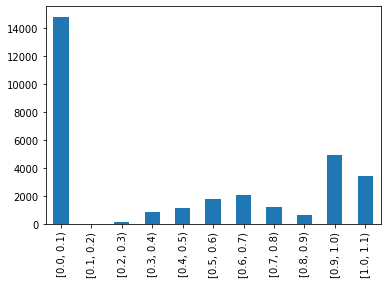

In [17]:
pred.ndcg_cut.value_counts().sort_index().plot(kind = 'bar');

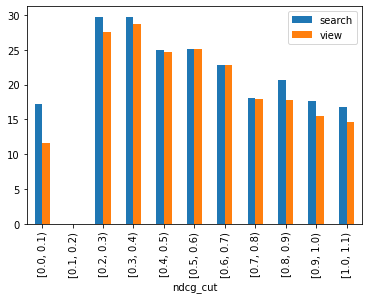

In [19]:
pred.groupby('ndcg_cut')[['search', 'view']].mean().plot(kind = 'bar');

<AxesSubplot:xlabel='top_score_cut'>

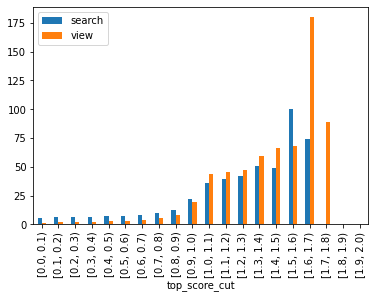

In [20]:
pred.groupby('top_score_cut')[['search', 'view']].mean().plot(kind = 'bar')

In [21]:
zero_ndcg = pd.Interval(0.0, 0.1, closed = 'left')
zero_topscore = pd.Interval(0.0, 0.1, closed = 'left')

In [22]:
pred['both_zeros'] = (pred.ndcg_cut == zero_ndcg) & (pred.top_score_cut == zero_topscore)
pred['ndcg_zero'] = (pred.ndcg_cut == zero_ndcg) 
pred['topscore_zero'] = (pred.top_score_cut == zero_topscore)

In [24]:
pred.search = pred.search.fillna(0)

(0.0, 100.0)

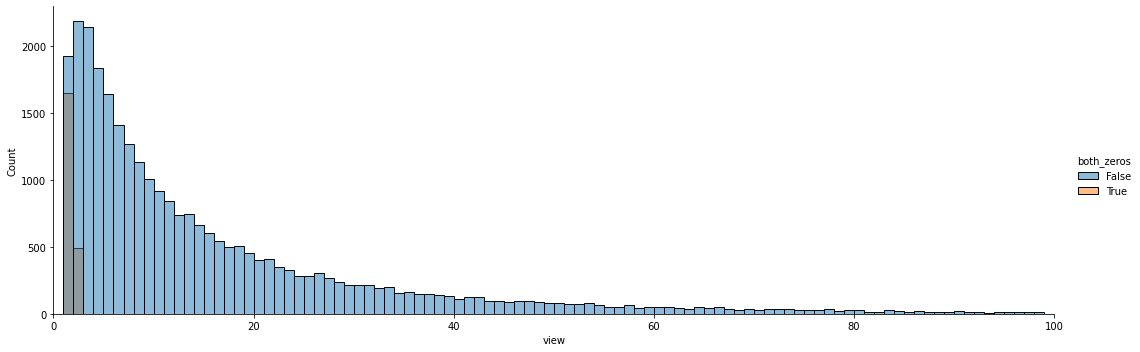

In [25]:
sns.displot(pred, x="view", hue="both_zeros", aspect = 3, bins = range(100))
plt.xlim(0, 100)

(0.0, 100.0)

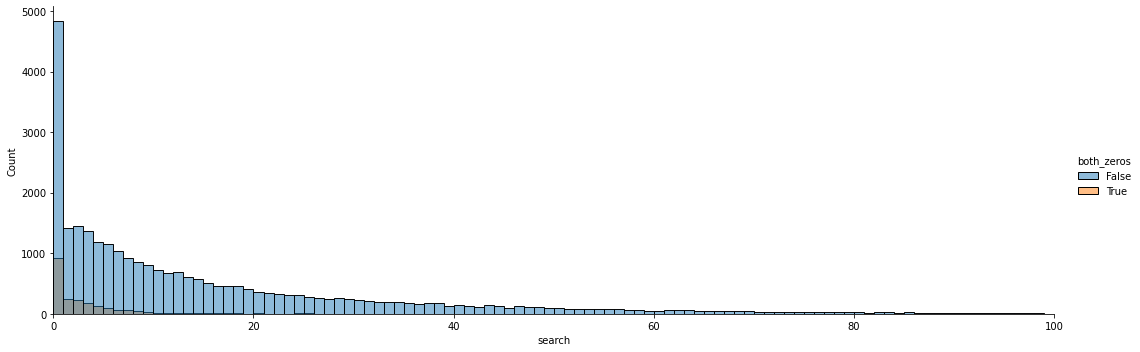

In [26]:
sns.displot(pred, x="search", hue="both_zeros", aspect = 3, bins = range(100))
plt.xlim(0, 100)

#### 11% of the seqs had only 1 view
and 8% had 2 views

In [30]:
pred.view.value_counts(normalize = True)

1.0      0.115483
2.0      0.086580
3.0      0.069316
4.0      0.059390
5.0      0.053021
           ...   
116.0    0.000032
158.0    0.000032
195.0    0.000032
180.0    0.000032
135.0    0.000032
Name: view, Length: 179, dtype: float64

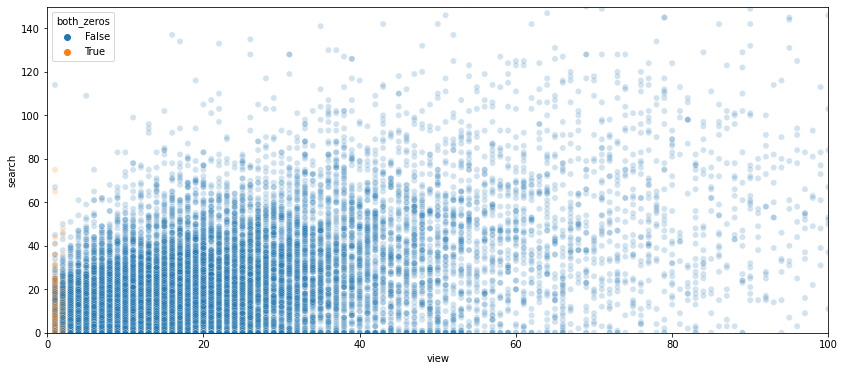

In [28]:
plt.figure(figsize = (14, 6))
plt.xlim(0, 100)
plt.ylim(0, 150)
sns.scatterplot(data=pred, x="view", y="search", hue="both_zeros", alpha = 0.2, );

<Figure size 1008x432 with 0 Axes>

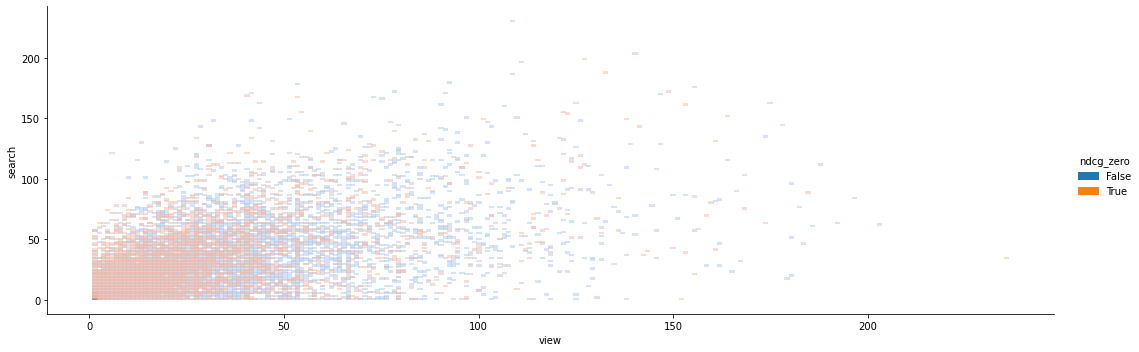

In [116]:
plt.figure(figsize = (14, 6))
# plt.xlim(0, 100)
# plt.ylim(0, 150)
sns.displot(data=pred, x="view", y="search", hue="ndcg_zero", alpha = 0.5, aspect = 3 );

<Figure size 1008x432 with 0 Axes>

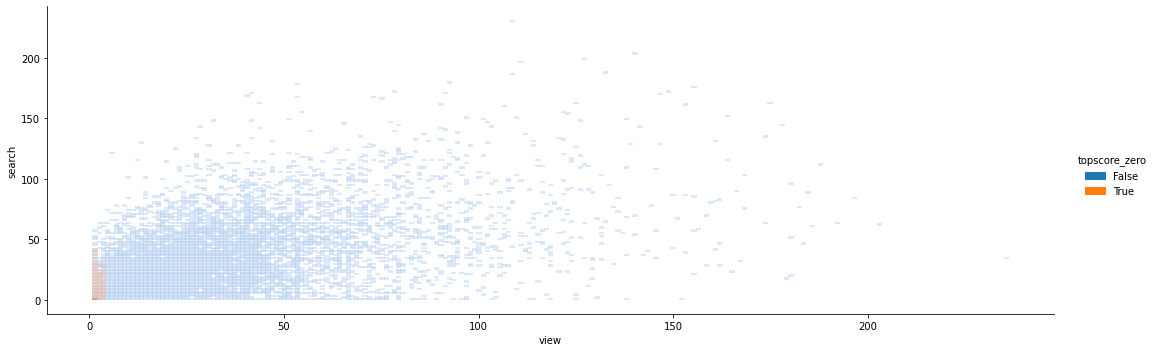

In [119]:
plt.figure(figsize = (14, 6))
# plt.xlim(0, 100)
# plt.ylim(0, 150)
sns.displot(data=pred, x="view", y="search", hue="topscore_zero", alpha = 0.4, aspect = 3);

### item_data

In [70]:
item_data_fn = 'item_data.pkl'
item_data_fp = os.path.join(processed_data_dir, item_data_fn)
item_data = pd.read_pickle(item_data_fp)

In [71]:
item_data

,item_id,title,domain_id,product_id,price,category_id,condition,title_lower,lang_domain,title_embs
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,NaN,1150000.00,MLM170527,new,casa sola en venta con gran patio solo pago de...,es,"[-0.1664, -0.03888, 0.03452, 0.0887, 0.0623, 0..."
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800.0,1392.83,MLM151595,new,resident evil origins collection nintendo swit...,es,"[0.0116, -0.02869, -0.0703, 0.3406, 0.1633, -0..."
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,NaN,350.00,MLM7697,new,falda de imitación piel negra,es,"[-0.1075, 0.2355, 0.01142, 0.0687, 0.09735, 0...."
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,NaN,3200.00,MLM9761,used,powercolor red devil radeon rx 580 8gb gddr5,es,"[0.1323, 0.001538, -0.2064, 0.4216, 0.1107, -0..."
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,NaN,1599.00,MLM1652,used,laptop hp nx6320 core duo con puerto db9 windo...,es,"[0.185, -0.008896, -0.2537, 0.391, 0.1273, -0...."
...,...,...,...,...,...,...,...,...,...,...
2102272,1099649,Carrinho De Bebê Stoke,MLB-BABY_STROLLERS,NaN,1600.00,MLB1386,used,carrinho de bebê stoke,pt,"[0.2024, 0.2474, 0.10767, -0.217, -0.2332, -0...."
2102273,1482187,Grelha Para Hambúrguer Preta Com Cabo Em Madei...,MLB-KITCHEN_SUPPLIES,NaN,69.90,MLB193425,new,grelha para hambúrguer preta com cabo em madei...,pt,"[-0.215, -0.01633, 0.10004, -0.205, 0.0761, -0..."
2102274,1118904,Meia Tam 7/8 Anti Embolia Trombose Antitrombo,MLB-SOCKS,NaN,118.00,MLB108791,new,meia tam 7/8 anti embolia trombose antitrombo,pt,"[-0.0987, 0.0804, -0.1415, -0.1965, -0.258, -0..."
2102275,237229,Pano De Boca Cremer Menina Luxo Bordado C/3 Und,MLB-DISPOSABLE_BABY_DIAPERS,NaN,26.90,MLB40629,new,pano de boca cremer menina luxo bordado c/3 und,pt,"[-0.03394, 0.04376, 0.0742, -0.02483, -0.05072..."


In [191]:
def get_trace(df, seq_sel = None):
    """None means all seqs are selected"""
    if seq_sel is None:
        trace = df.copy()
    else:
        trace = df[df.seq.isin(seq_sel)].copy()
        
    trace = trace.query("event_type != 'buy'")
    trace = trace.groupby('seq').event_type.value_counts().unstack().fillna(0).astype(int)
    
    return trace

pred_seqs = pred.seq.values
trace = get_trace(train, seq_sel = pred_seqs)

In [95]:
views = train[train.seq.isin(pred_seqs)]
views = views.query("event_type == 'view'")

In [96]:
views = pd.merge(views, item_data[['item_id', 'price', 'condition', 'lang_domain']], 
                 left_on = 'event_info', right_on = 'item_id', 
                 how = 'left')

In [97]:
views

,seq,item_bought,event_info,event_timestamp,event_type,timezone,time_diff,item_id,price,condition,lang_domain
0,330059,NaN,868526,2019-10-01 15:19:39,view,0400,NaN,868526,70.00,new,pt
1,197609,NaN,1566370,2019-10-22 09:29:16,view,0400,NaN,1566370,698.49,new,pt
2,197668,NaN,594551,2019-10-08 09:25:21,view,0400,NaN,594551,189.00,new,pt
3,175108,NaN,1937245,2019-10-17 09:41:12,view,0400,NaN,1937245,149.90,new,pt
4,270052,NaN,488350,2019-10-04 20:03:20,view,0400,NaN,488350,1499.99,new,pt
...,...,...,...,...,...,...,...,...,...,...,...
478690,150373,NaN,899680,2019-10-30 16:22:09,view,0400,21.0,899680,319.99,new,pt
478691,150373,NaN,358838,2019-10-30 16:22:17,view,0400,8.0,358838,319.97,new,pt
478692,150373,NaN,1390046,2019-10-30 16:25:09,view,0400,84.0,1390046,55.90,new,pt
478693,150373,NaN,358838,2019-10-30 17:06:16,view,0400,4.0,358838,319.97,new,pt


In [108]:
agg_dict = {'price': 'mean', 
            'condition': lambda x: (x == 'new').mean(), 
            'lang_domain': lambda x: (x == 'pt').mean()} # how to get the first element?

In [110]:
views = views.groupby('seq').agg(agg_dict)

In [111]:
views

,price,condition,lang_domain
seq,,,
1,153.337500,0.750000,1.0
11,588.184205,0.954545,1.0
39,740.300000,1.000000,1.0
42,663.288235,1.000000,0.0
72,508.903409,0.977273,1.0
...,...,...,...
413130,110.958571,1.000000,1.0
413143,2589.966667,0.666667,1.0
413151,40.000000,1.000000,1.0


In [113]:
trace = pd.concat([trace, views], axis = 1)

In [114]:
trace

,search,view,price,condition,lang_domain
seq,,,,,
1,5,8,153.337500,0.750000,1.0
11,43,88,588.184205,0.954545,1.0
39,21,3,740.300000,1.000000,1.0
42,10,34,663.288235,1.000000,0.0
72,78,44,508.903409,0.977273,1.0
...,...,...,...,...,...
413130,7,14,110.958571,1.000000,1.0
413143,14,3,2589.966667,0.666667,1.0
413151,0,2,40.000000,1.000000,1.0


In [129]:
trace.price = trace.price.fillna(trace.price.mean())

### seq features 
to improve ndcg model prediction

In [147]:
X = trace[['search', 'view']]
y = pred[['seq', 'ndcg']].set_index('seq')
y = y.ndcg == 0 # classification problem

### model to predict ndcg

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [149]:
rf = RandomForestClassifier()

In [150]:
param_grid = {'n_estimators': [50, 100, 200, 500], 
              'max_depth': [3, 5, 7, 9], 
              'min_samples_split': [0.1, 0.03, 0.01, 0.003]}

In [151]:
gs = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose = 1, n_jobs = 4)

In [152]:
gs.fit(X, y)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:  1.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_split': [0.1, 0.03, 0.01, 0.003],
                         'n_estimators': [50, 100, 200, 500]},
             verbose=1)

In [153]:
gs.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_split=0.01, n_estimators=200)

In [154]:
gs.best_score_

0.6300153709765323

#### Viz predictions

In [173]:
X = [(s, v) for s in range(100) for v in range(100)]
X = pd.DataFrame(X)
X['ndcg_pred'] = gs.predict_proba(X)[:, 1]
X.columns = ['search', 'view', 'ndcg_pred']

In [185]:
X['zero_ndcg_prob_gt_.7'] = X.ndcg_pred > 0.7

In [178]:
X['zero_ndcg_prob_gt_.8'] = X.ndcg_pred > 0.8

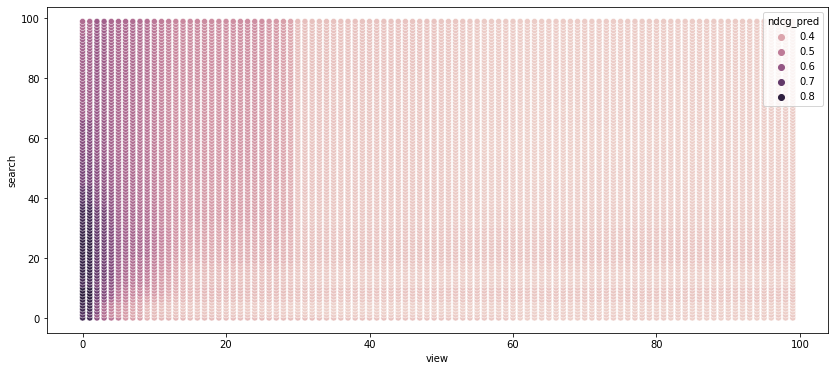

In [176]:
plt.figure(figsize = (14, 6))
sns.scatterplot(data=X, x="view", y="search", hue="ndcg_pred" );

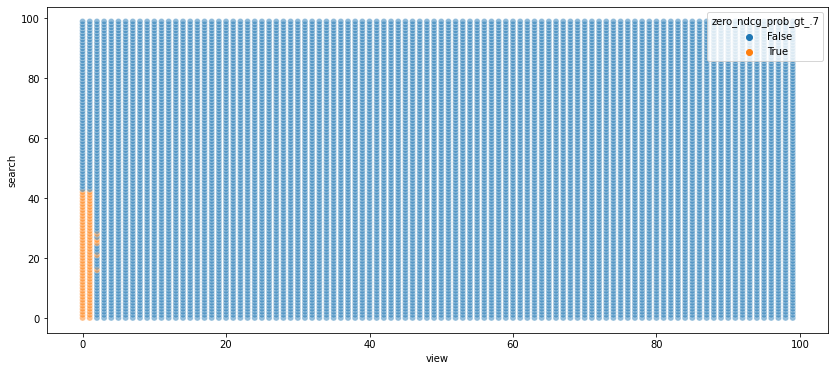

In [186]:
plt.figure(figsize = (14, 6))
sns.scatterplot(data=X, x="view", y="search", hue="zero_ndcg_prob_gt_.7" , alpha = 0.5);

### generate test seq ids with low ndcg expectation

In [193]:
test_trace = get_trace(test)

In [195]:
test_trace['ndcg_zero_pred'] = gs.predict_proba(test_trace)[:, 1]

In [198]:
ndcg_zero_pred_fn = 'ndcg_zero_pred.pkl'
ndcg_zero_pred_fp = os.path.join(interim_data_dir, ndcg_zero_pred_fn)
test_trace.to_pickle(ndcg_zero_pred_fp)

In [201]:
test_trace.ndcg_zero_pred.describe(percentiles = np.arange(0, 1.0, 0.1))

count    177070.000000
mean          0.495350
std           0.151305
min           0.297560
0%            0.297560
10%           0.326494
20%           0.347105
30%           0.381243
40%           0.415090
50%           0.450502
60%           0.513342
70%           0.561036
80%           0.641514
90%           0.761431
max           0.804611
Name: ndcg_zero_pred, dtype: float64